In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import datetime
from scipy import stats

In [2]:
df = pd.read_csv('transaction.csv', header = None, index_col = 0)
df.columns = ['type', 'from', 'to', 'date', 'punk_id', 'amount_in_eth', 'amount_in_dol']
df = df[ ['punk_id'] + [ col for col in df.columns if col != 'punk_id' ] ]

In [3]:
df['punk_id'] = df['punk_id'].astype('category')
df['type'] = df['type'].astype('category')
df['from'] = df['from'].astype(str)
df['to'] = df['to'].astype(str)
df['date'] = pd.to_datetime(df['date'], format = '%Y.%m.%d')

In [4]:
#Fix amount values in eth and dollar
df['amount_in_eth'] = df['amount_in_eth'].astype(str)
df['amount_in_eth'] = df['amount_in_eth'].str.replace('Y', '')
df['amount_in_eth'] = df['amount_in_eth'].str.replace('Z', '')
df['amount_in_eth'] = df['amount_in_eth'].str.replace('M', '')
df['amount_in_eth'] = df['amount_in_eth'].str.replace('T', '')
df['amount_in_eth'] = df['amount_in_eth'].str.replace('B', '')
df['amount_in_eth'] = df['amount_in_eth'].replace(',', '', regex=True)
df['amount_in_eth'] = df['amount_in_eth'].astype(float)

df['amount_in_dol'] = df['amount_in_dol'].astype(str)
df['amount_in_dol'] = df['amount_in_dol'].str.replace('Y', '')
df['amount_in_dol'] = df['amount_in_dol'].str.replace('B', '')
df['amount_in_dol'] = df['amount_in_dol'].str.replace('T', '')
df['amount_in_dol'] = df['amount_in_dol'].str.replace('P', '')
df['amount_in_dol'] = df['amount_in_dol'].str.replace('Z', '')
df['amount_in_dol'] = df['amount_in_dol'].replace('<', '', regex=True)
df['amount_in_dol'] = df['amount_in_dol'].replace(',', '', regex=True)
df['amount_in_dol'] = df['amount_in_dol'].astype(float)

In [5]:
df['amount_in_eth'] = df['amount_in_eth'].fillna(0)
df['amount_in_dol'] = df['amount_in_dol'].fillna(0)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115734 entries, 0 to 49
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   punk_id        115734 non-null  category      
 1   type           115734 non-null  category      
 2   from           115734 non-null  object        
 3   to             115734 non-null  object        
 4   date           115734 non-null  datetime64[ns]
 5   amount_in_eth  115734 non-null  float64       
 6   amount_in_dol  115734 non-null  float64       
dtypes: category(2), datetime64[ns](1), float64(2), object(2)
memory usage: 6.0+ MB


In [7]:
df.head()

,punk_id,type,from,to,date,amount_in_eth,amount_in_dol
0,,,,,,,
0,0,Bid Withdrawn,0x983ace,nan,2021-05-10,250.0,1030000.0
1,0,Bid,0x983ace,nan,2021-04-11,250.0,537615.0
2,0,Bid Withdrawn,0xd7510a,nan,2021-03-03,100.0,160973.0
3,0,Bid,0xd7510a,nan,2021-02-20,100.0,188897.0
4,0,Bid Withdrawn,natealex,nan,2020-09-16,69.0,25532.0


# Bids and Sales

In [8]:
df.type.value_counts()

Offered            40175
Bid                19933
Sold               13531
Bid Withdrawn      11273
Transfer           10530
Claimed            10000
Offer Withdrawn     6149
(Wrap)              2218
(Unwrap)            1925
Name: type, dtype: int64

In [9]:
df_bids = df.copy()
df_bids = df_bids[df_bids['type'].str.contains("Bid")] #Filter df with bids only
df_bids = df_bids[~df_bids.type.str.contains("Withdrawn")] #Drop rows with withdrawn bids

total_bids = pd.DataFrame(df_bids.groupby('punk_id')['amount_in_eth'].sum()) #Sum the amount of bids in eth for each punk
total_bids['amount_in_dol'] = df_bids.groupby('punk_id')['amount_in_dol'].sum()
total_bids.head()

,amount_in_eth,amount_in_dol
punk_id,,
0,630.45,787016.0
1,177.93,78995.0
2,65.18,28325.0
3,42.79,14347.0
4,37.50,72553.0


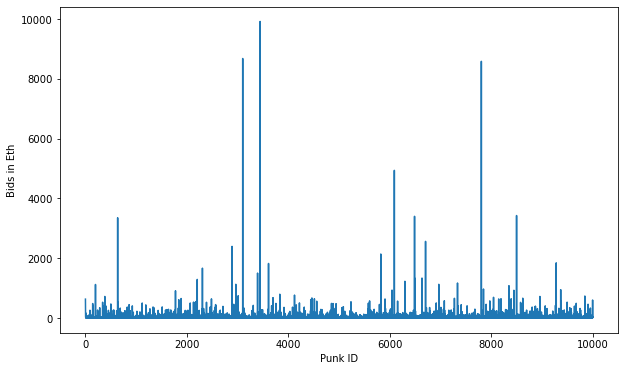

In [10]:
plt.rcParams['figure.figsize'] = (10,6)
plt.plot(total_bids.index, total_bids['amount_in_eth'])
plt.xlabel("Punk ID")
plt.ylabel("Bids in Eth")
plt.show()

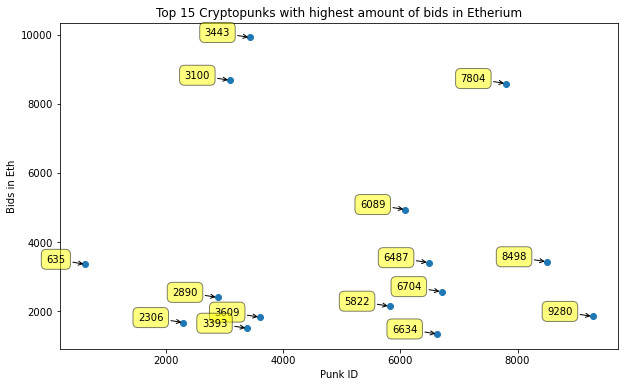

In [11]:
plt.rcParams['figure.figsize'] = (10,6)
top_bids = total_bids.nlargest(15,'amount_in_eth') #Select top 15 punks with highest amount in bids
labels = top_bids.index

plt.scatter(top_bids.index, top_bids['amount_in_eth'])
for label, x, y in zip(labels, top_bids.index, top_bids['amount_in_eth']):
  plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 0),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

plt.title("Top 15 Cryptopunks with highest amount of bids in Etherium")
plt.xlabel("Punk ID")
plt.ylabel("Bids in Eth")
plt.show()

In [12]:
df_sold = df.copy()
df_sold = df_sold[df_sold['type'].str.contains("Sold")] 

total_sales = pd.DataFrame(df_sold.groupby('punk_id')['amount_in_eth'].sum())
total_sales['amount_in_dol'] = df_sold.groupby('punk_id')['amount_in_dol'].sum()
total_sales.head()

,amount_in_eth,amount_in_dol
punk_id,,
0,27.58,3528.0
1,91.42,41567.0
2,0.00,0.0
3,0.00,0.0
4,0.00,0.0


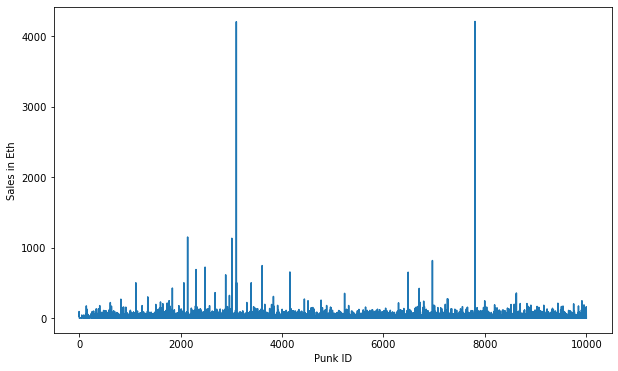

In [13]:
plt.rcParams['figure.figsize'] = (10,6)
plt.plot(total_sales.index, total_sales['amount_in_eth'])
plt.xlabel("Punk ID")
plt.ylabel("Sales in Eth")
plt.show()

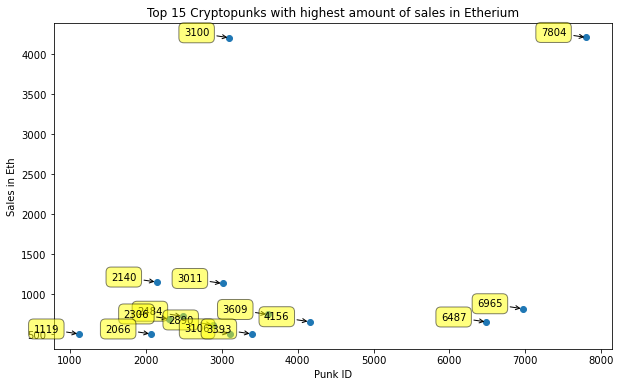

In [14]:
plt.rcParams['figure.figsize'] = (10,6)
top_sales = total_sales.nlargest(15,'amount_in_eth') #Select top 15 punks with highest amount in sales
labels = top_sales.index

plt.scatter(top_sales.index, top_sales['amount_in_eth'])
for label, x, y in zip(labels, top_sales.index, top_sales['amount_in_eth']):
  plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 0),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

plt.title("Top 15 Cryptopunks with highest amount of sales in Etherium")
plt.xlabel("Punk ID")
plt.ylabel("Sales in Eth")
plt.show()

In [15]:
#Create dataframe with counts of each transaction type for each punk
types_df = df.groupby(['punk_id', 'type']).size().reset_index().pivot(columns='type', index='punk_id', values=0)
types_df

type,(Unwrap),(Wrap),Bid,Bid Withdrawn,Claimed,Offer Withdrawn,Offered,Sold,Transfer
punk_id,,,,,,,,,
0,0,0,19,8,1,0,3,3,1
1,0,0,12,6,1,6,20,3,5
2,0,0,14,9,1,0,0,0,0
3,0,0,11,3,1,0,0,0,0
4,0,0,6,5,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...
9995,0,0,3,2,1,0,0,0,1
9996,0,0,2,2,1,0,0,0,0
9997,3,3,9,5,1,1,7,2,5


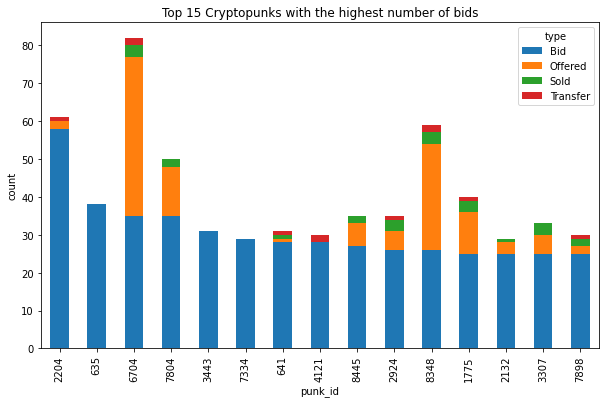

In [16]:
most_popular_by_bid = types_df.nlargest(15,'Bid')
most_popular_by_bid = most_popular_by_bid.drop(['(Wrap)', '(Unwrap)', 'Bid Withdrawn', 'Claimed', 'Offer Withdrawn'], axis=1)
most_popular_by_bid.plot(kind='bar', stacked=True, title = 'Top 15 Cryptopunks with the highest number of bids')
plt.ylabel('count')
plt.show()

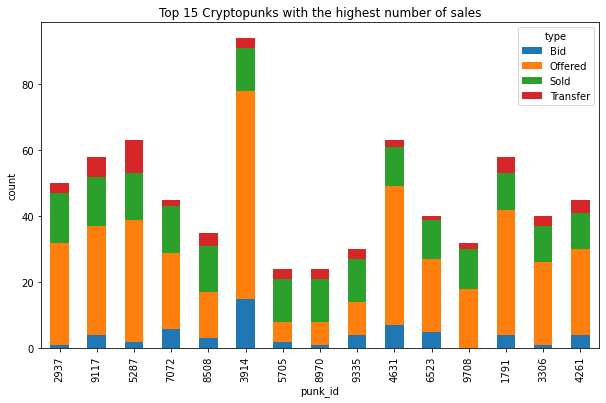

In [17]:
most_popular_by_sales = types_df.nlargest(15,'Sold')
most_popular_by_sales = most_popular_by_sales.drop(['(Wrap)', '(Unwrap)', 'Bid Withdrawn', 'Claimed', 'Offer Withdrawn'], axis=1)
most_popular_by_sales.plot(kind='bar', stacked=True, title = 'Top 15 Cryptopunks with the highest number of sales')
plt.ylabel('count')
plt.show()

In [18]:
#Cryptopunks with no bids or sales
no_bids_sales = types_df.loc[(types_df['Bid'] == 0) & (types_df['Sold'] == 0)]
no_bids_sales

type,(Unwrap),(Wrap),Bid,Bid Withdrawn,Claimed,Offer Withdrawn,Offered,Sold,Transfer
punk_id,,,,,,,,,
11,0,0,0,0,1,0,0,0,0
18,0,0,0,0,1,0,0,0,0
26,0,0,0,0,1,0,0,0,0
27,0,0,0,0,1,0,0,0,0
29,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...
9982,0,0,0,0,1,3,2,0,0
9983,0,0,0,0,1,0,0,0,1
9986,0,0,0,0,1,0,0,0,1


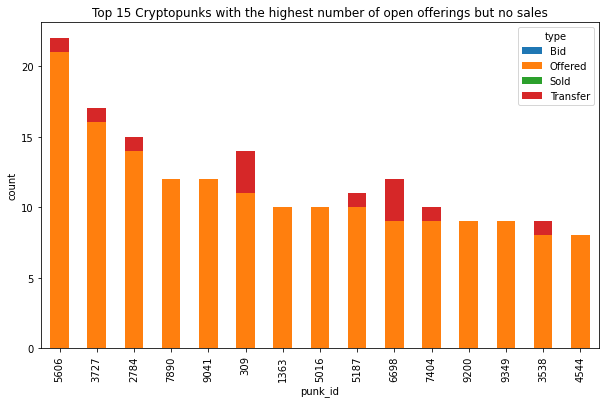

In [19]:
most_offered = no_bids_sales.nlargest(15,'Offered')
most_offered = most_offered.drop(['(Wrap)', '(Unwrap)', 'Bid Withdrawn', 'Claimed', 'Offer Withdrawn'], axis=1)
most_offered.plot(kind='bar', stacked=True, title = 'Top 15 Cryptopunks with the highest number of open offerings but no sales')
plt.ylabel('count')
plt.show()

In [20]:
#Cryptopunks with zero sales
no_sales = types_df.loc[types_df['Sold'] == 0]
no_sales

type,(Unwrap),(Wrap),Bid,Bid Withdrawn,Claimed,Offer Withdrawn,Offered,Sold,Transfer
punk_id,,,,,,,,,
2,0,0,14,9,1,0,0,0,0
3,0,0,11,3,1,0,0,0,0
4,0,0,6,5,1,0,0,0,0
5,0,1,6,4,1,0,0,0,2
6,0,0,4,2,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...
9993,0,0,0,0,1,0,0,0,1
9994,0,0,1,0,1,0,0,0,1
9995,0,0,3,2,1,0,0,0,1


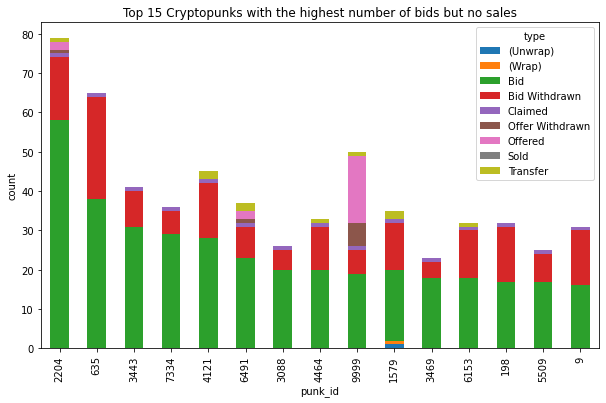

In [21]:
#Punks with the highest amount of bids but no sales
most_bids = no_sales.nlargest(15,'Bid')
most_bids.plot(kind='bar', stacked=True, title = 'Top 15 Cryptopunks with the highest number of bids but no sales')
plt.ylabel('count')
plt.show()

In [22]:
#Creating seperate df for amount of sales/transactions against each cryptopunk
sales_count = pd.DataFrame(types_df['Sold'])
sales_count

,Sold
punk_id,
0,3
1,3
2,0
3,0
4,0
...,...
9995,0
9996,0
9997,2


# User Activity

In [23]:
#Looking at the 'from' column
from_df = df.groupby(['from', 'type']).size().reset_index().pivot(columns='type', index='from', values=0)

agg_from = df.assign(
 total_bid_amount = np.where(df['type']=='Bid',df.amount_in_eth, 0),
 total_sales_amount = np.where(df['type']=='Sold',df.amount_in_eth, 0)
 ).groupby('from').agg({'total_bid_amount':sum, 'total_sales_amount':sum})

from_df = from_df.join(agg_from, on=from_df.index, how='left', lsuffix='_', rsuffix='_')
from_df

,(Unwrap),(Wrap),Bid,Bid Withdrawn,Claimed,Offer Withdrawn,Offered,Sold,Transfer,total_bid_amount,total_sales_amount
from,,,,,,,,,,,
007,0,0,1,1,0,0,0,1,0,0.10,0.85
0x000c1c…,0,0,0,0,0,0,0,7,19,0.00,3.60
0x002ca2,0,0,1,1,0,0,0,0,1,0.05,0.00
0x003a97,0,0,0,0,0,0,0,0,10,0.00,0.00
0x00493a,0,0,0,0,0,0,0,0,2,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...
👱‍♀.eth,0,0,20,10,0,0,0,7,4,422.50,215.25
👱🏻‍♂.e…,0,0,2,2,0,0,0,0,0,48.50,0.00
🖕🖕🖕.e…,0,0,4,3,0,0,0,0,1,13.29,0.00


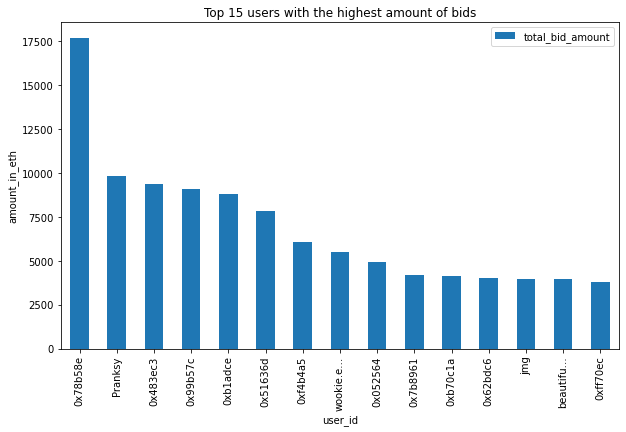

In [24]:
user_bids= from_df.nlargest(15,'total_bid_amount')
user_bids.plot(y = 'total_bid_amount', kind='bar', title = 'Top 15 users with the highest amount of bids')
plt.xlabel('user_id')
plt.ylabel('amount_in_eth')
plt.show()

Interestingly, the account page for user 0x78b58e shows no records of the bids or transaction made by this account. But we can verify all their bids and purchases through the transaction history data. Example - Punk 550.

Same for user 0x6611fe below, i.e punk 382.

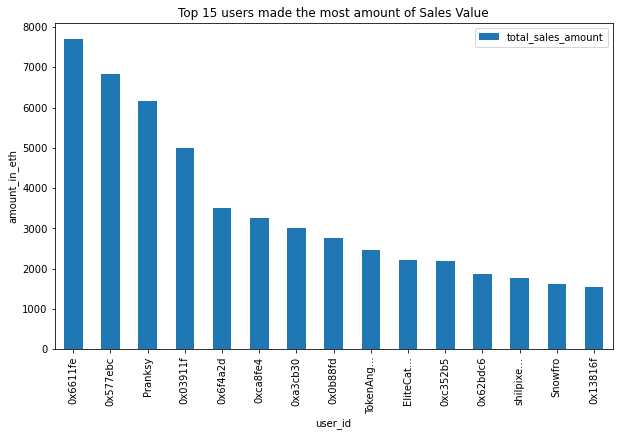

In [25]:
user_sales= from_df.nlargest(15,'total_sales_amount')
user_sales.plot(y = 'total_sales_amount', kind='bar', title = 'Top 15 users made the most amount of Sales Value')
plt.xlabel('user_id')
plt.ylabel('amount_in_eth')
plt.show()

In [26]:
#Looking at the 'to' column
to_df = df.groupby(['to', 'type']).size().reset_index().pivot(columns='type', index='to', values=0)

agg_to = df.assign(
 total_sales_amount = np.where(df['type']=='Sold',df.amount_in_eth, 0)
 ).groupby('to').agg({'total_sales_amount':sum})

to_df = to_df.join(agg_to, on=to_df.index, how='left', lsuffix='_', rsuffix='_')
to_df.head()

,(Unwrap),(Wrap),Bid,Bid Withdrawn,Claimed,Offer Withdrawn,Offered,Sold,Transfer,total_sales_amount
to,,,,,,,,,,
007,0,0,0,0,0,0,0,1,0,0.7
0x000000,0,0,0,0,0,0,23,0,2,0.0
0x000002,0,0,0,0,5,0,0,0,0,0.0
0x000003,0,0,0,0,1,0,0,0,0,0.0
0x00014f,0,0,0,0,0,0,0,0,1,0.0


<AxesSubplot:title={'center':'Top 15 users with the highest amount of Purchase Value'}, xlabel='to'>

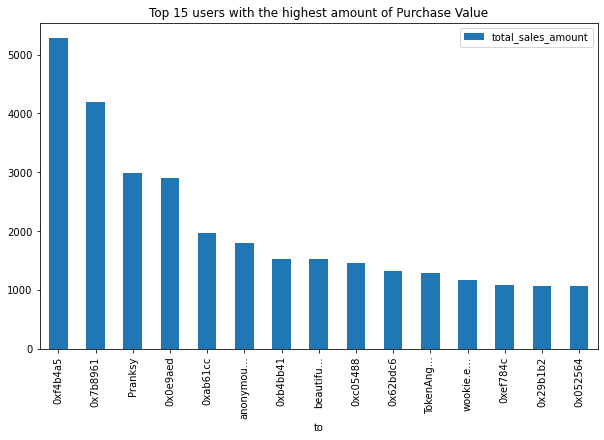

In [27]:
user_purchase = to_df.nlargest(15,'total_sales_amount')
user_purchase.plot(y='total_sales_amount', kind='bar', title = 'Top 15 users with the highest amount of Purchase Value')

# Dates

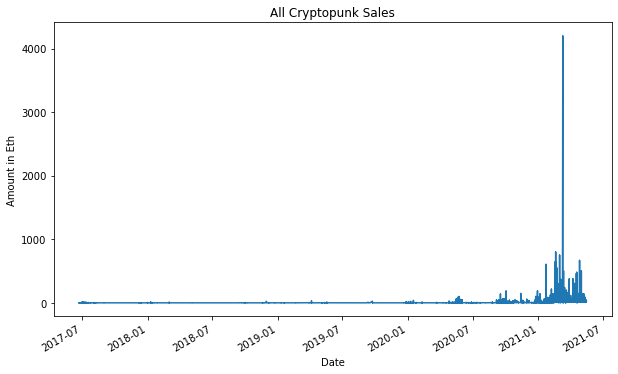

In [28]:
df_sold.plot(x='date', y='amount_in_eth', legend=None)
plt.title("All Cryptopunk Sales")
plt.xlabel('Date')
plt.ylabel('Amount in Eth')
plt.savefig('All Sales', transparent=True)
plt.show()
plt.close()

In [29]:
date_df = df.groupby(['date', 'type']).size().reset_index().pivot(columns='type', index='date', values=0)

#Join aggregate sales
agg_sales = df.assign(
 sales_in_eth = np.where(df['type']=='Sold',df.amount_in_eth, 0)
 ).groupby('date').agg({'sales_in_eth':sum})
date_df = date_df.join(agg_sales, on=date_df.index, how='left', lsuffix='_', rsuffix='_')

#Join aggregate bids
agg_bids = df.assign(
 bids_in_eth = np.where(df['type']=='Bid',df.amount_in_eth, 0)
 ).groupby('date').agg({'bids_in_eth':sum})
date_df = date_df.join(agg_bids, on=date_df.index, how='left', lsuffix='_', rsuffix='_')

date_df

,(Unwrap),(Wrap),Bid,Bid Withdrawn,Claimed,Offer Withdrawn,Offered,Sold,Transfer,sales_in_eth,bids_in_eth
date,,,,,,,,,,,
2017-06-23,0,0,32,2,10000,0,39,20,2,3.09,5.77
2017-06-24,0,0,26,6,0,15,240,22,6,4.27,4.51
2017-06-25,0,0,685,206,0,0,104,13,5,1.80,44.15
2017-06-26,0,0,1020,17,0,7,41,18,56,2.44,68.90
2017-06-27,0,0,113,5,0,4,32,36,1,8.00,29.73
...,...,...,...,...,...,...,...,...,...,...,...
2021-05-12,12,28,39,28,0,35,257,30,35,708.22,696.74
2021-05-13,16,12,94,58,0,21,239,50,16,868.23,1777.67
2021-05-14,4,4,62,34,0,11,124,26,46,620.28,1198.69


In [30]:
#mask = (date_df.index > '2017-06-27') & (date_df.index <= '2021-05-16')
#new_date_df = date_df.loc[mask]
new_date_df = date_df.copy()
new_date_df = new_date_df.drop(['(Unwrap)', '(Wrap)', 'Bid Withdrawn', 'Claimed', 'Offer Withdrawn', 'sales_in_eth', 'bids_in_eth'], axis=1)
new_date_df.head()

,Bid,Offered,Sold,Transfer
date,,,,
2017-06-23,32,39,20,2
2017-06-24,26,240,22,6
2017-06-25,685,104,13,5
2017-06-26,1020,41,18,56
2017-06-27,113,32,36,1


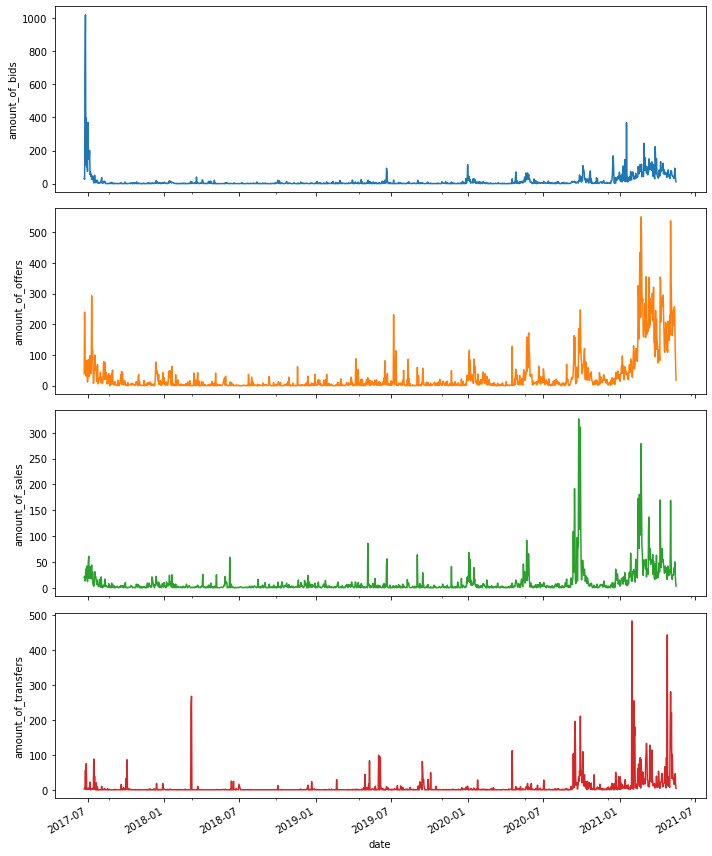

In [31]:
axes = new_date_df.plot(subplots=True, figsize=(10,12), sharex=True, legend=None)
axes[0].set_ylabel('amount_of_bids')
axes[1].set_ylabel('amount_of_offers')
axes[2].set_ylabel('amount_of_sales')
axes[3].set_ylabel('amount_of_transfers')

plt.tight_layout()
plt.savefig('Activity', transparent=True)
plt.show()
plt.close()

<ipython-input-32-016207ecb762>:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  date_df['2021'].sales_in_eth.plot(ax=ax1, title = 'Sales in Eth (2021)')
<ipython-input-32-016207ecb762>:9: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  date_df['2021'].bids_in_eth.plot(ax=ax2, title = 'Bids in Eth (2021)')


<Figure size 720x432 with 0 Axes>

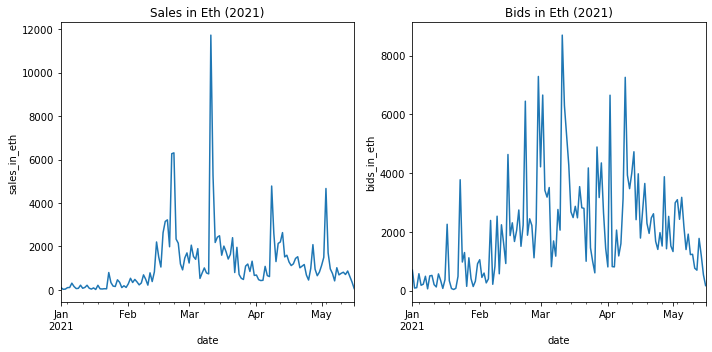

In [32]:
plt.figure(1)
fig = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax1 = plt.subplot(121)
date_df['2021'].sales_in_eth.plot(ax=ax1, title = 'Sales in Eth (2021)')
plt.ylabel('sales_in_eth')

ax2 = plt.subplot(122)
date_df['2021'].bids_in_eth.plot(ax=ax2, title = 'Bids in Eth (2021)')
plt.ylabel('bids_in_eth')

plt.tight_layout()
plt.savefig('Activity in 2021', transparent=True)
plt.show()
plt.close()

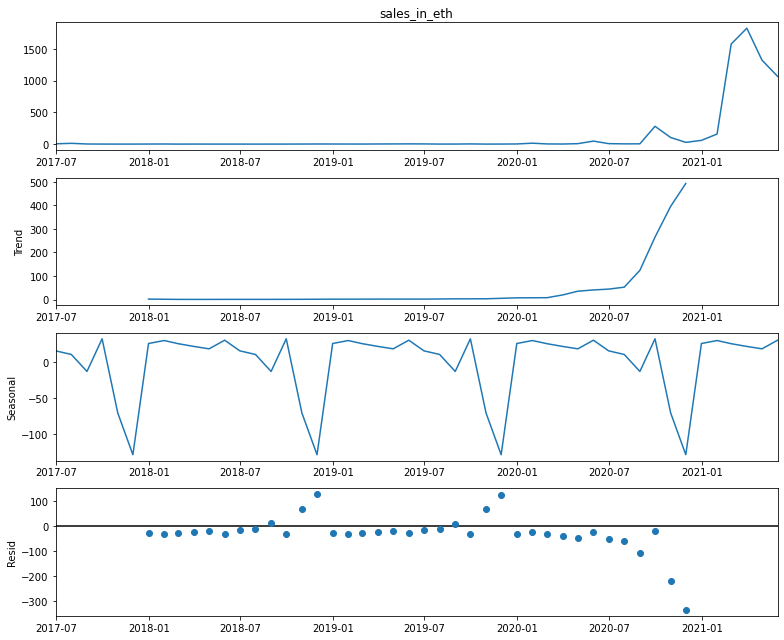

In [264]:
from pylab import rcParams
import statsmodels.api as sm

date_df_month = date_df.resample("M").mean()

rcParams['figure.figsize'] = 11, 9
decomposition = sm.tsa.seasonal_decompose(date_df_month['sales_in_eth'], model='Additive')
fig = decomposition.plot()
plt.show()